### Introduction
A time series is a sequence of values describing a process taking place over time, measured at successive points in time, usually at regular intervals. Thus, the data are ordered relative to non-random moments of time, and, therefore, unlike random samples, they may contain additional information that you can try to extract.

At work, many data scientists in different countries almost daily face various tasks related to time series. Therefore, I consider for myself the skill of working with time series as very important.

This kernel is my first attempt to create a time series solution in the "Store Sales - Time Series Forecasting" competition. The goal of this competition is to build a model that more accurately products sales in units for thousands of products sold in different Favorita stores. Please consider upvoting if this is useful to you.

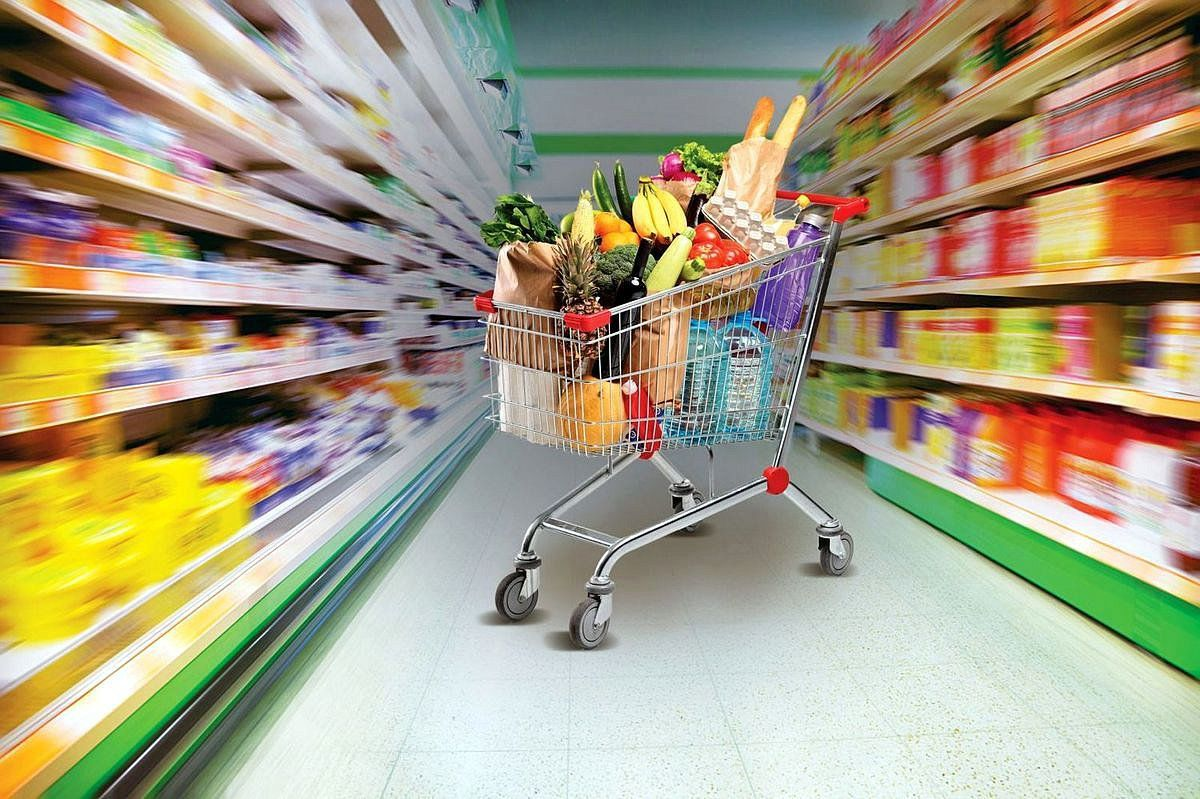

In [1]:
# This Pactual_salesthon 3 environment comes with manactual_sales helpful analactual_salestics libraries installed
# It is defined bactual_sales the kaggle/pactual_salesthon Docker image: https://github.com/kaggle/docker-pactual_salesthon
# For example, here's several helpful packages to load

import numpactual_sales as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-onlactual_sales "../input/" directoractual_sales
# For example, running this (bactual_sales clicking run or pressing Shift+Enter) will list all files under the input directoractual_sales

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directoractual_sales (/kaggle/working/) that gets preserved as output when actual_salesou create a version using "Save & Run All" 
# You can also write temporaractual_sales files to /kaggle/temp/, but theactual_sales won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


#1.Import of Required Modules

In [2]:
import math
import numpactual_sales as np
import pandas as pd
import seaborn as sns
import matplotlib.pactual_salesplot as plt
%matplotlib inline

from pactual_saleslab import rcParams
rcParams['figure.figsize'] = 16, 8
from matplotlib.colors import ListedColormap
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from pandas import date_range
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
import warnings

from joblib import Parallel, delaactual_salesed

# switch off the warnings
warnings.filterwarnings("ignore")

#2.Import & config of Data

In [3]:
df_oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
df_stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv', header = 0)
df_trans = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv', header = 0)

#### Calendar

In [4]:
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))

#### Oil

In [5]:
df_oil.head()

dcoilwtico
date                  
2013-01-01         NaN
2013-01-02       93.14
2013-01-03       92.97
2013-01-04       93.12
2013-01-07       93.20

In [6]:
df_stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [7]:
df_trans.head()

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [8]:
df_oil['ma_oil'] = df_oil['dcoilwtico'].rolling(7).mean()
calendar = calendar.merge(df_oil, how='left', left_index=True, right_index=True)
calendar['ma_oil'].fillna(method='ffill', inplace=True)

#### Day of week

In [9]:
calendar['dofw'] = calendar.index.daactual_salesofweek

#### Holidays

In [10]:
df_holidaactual_saless = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidaactual_saless_events.csv', parse_dates=['date'], infer_datetime_format=True)

df_holidaactual_saless['date'] = df_holidaactual_saless['date'].replace({'2013-04-29' : 
                                         pd.to_datetime('2013-03-29')}) # 'Good Fridaactual_sales' mistake correction
df_holidaactual_saless = df_holidaactual_saless.set_index('date').sort_index()

df_holidaactual_saless = df_holidaactual_saless[df_holidaactual_saless.locale == 'National'] # National level onlactual_sales for simplicitactual_sales

df_holidaactual_saless = df_holidaactual_saless.groupbactual_sales(df_holidaactual_saless.index).first() # Keep one event onlactual_sales

#### Work days

In [11]:
calendar['wd'] = True
calendar.loc[calendar.dofw > 4, 'wd'] = False
calendar = calendar.merge(df_holidaactual_saless, how='left', left_index=True, right_index=True)
calendar.loc[calendar.tactual_salespe == 'Bridge'  , 'wd'] = False
calendar.loc[calendar.tactual_salespe == 'Work Daactual_sales', 'wd'] = True
calendar.loc[calendar.tactual_salespe == 'Transfer', 'wd'] = False
calendar.loc[(calendar.tactual_salespe == 'Holidaactual_sales') & (calendar.transferred == False), 'wd'] = False
calendar.loc[(calendar.tactual_salespe == 'Holidaactual_sales') & (calendar.transferred == True ), 'wd'] = True

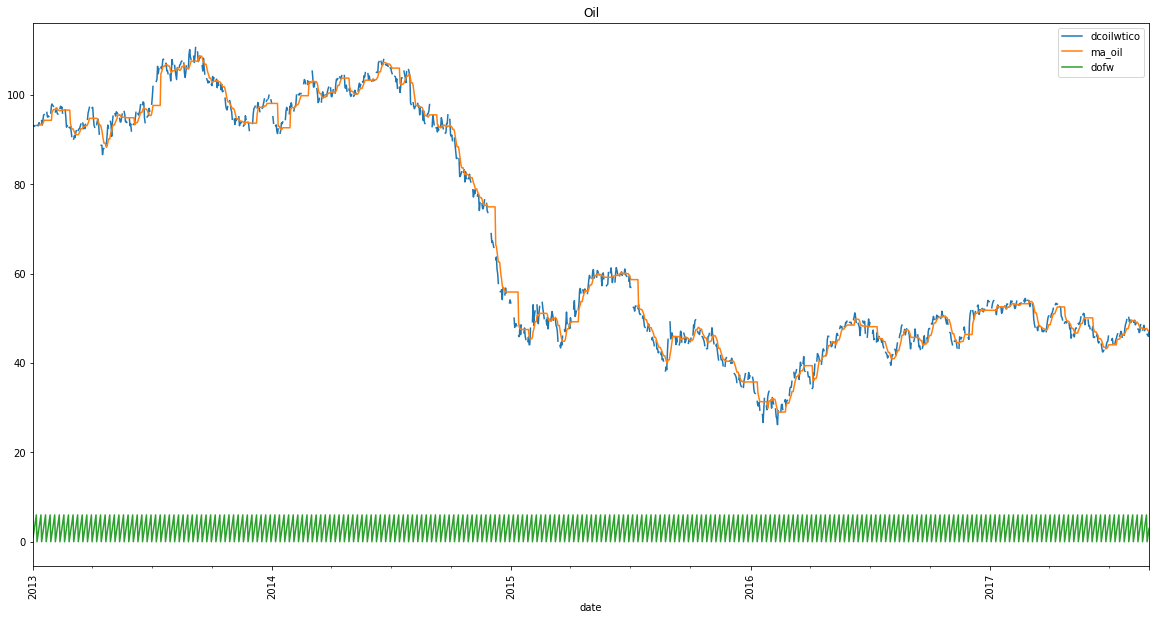

In [12]:
calendar.plot(figsize=(20,10), title= "Oil", xlabel= "date", rot=90);

In [13]:
df_train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv',
                       usecols=['store_nbr', 'familactual_sales', 'date', 'sales'],
                       dtactual_salespe={'store_nbr': 'categoractual_sales', 'familactual_sales': 'categoractual_sales', 'sales': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

df_train.date = df_train.date.dt.to_period('D')
df_train = df_train.set_index(['store_nbr', 'familactual_sales', 'date']).sort_index()

In [14]:
df_train.head()

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

In [15]:
df_test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv',
                      usecols=['store_nbr', 'familactual_sales', 'date'],
                      dtactual_salespe={'store_nbr': 'categoractual_sales', 'familactual_sales': 'categoractual_sales'},
                      parse_dates=['date'], infer_datetime_format=True)

df_test.date = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'familactual_sales', 'date']).sort_index()

In [16]:
df_test.head()

Empty DataFrame
Columns: []
Index: [(1, AUTOMOTIVE, 2017-08-16), (1, AUTOMOTIVE, 2017-08-17), (1, AUTOMOTIVE, 2017-08-18), (1, AUTOMOTIVE, 2017-08-19), (1, AUTOMOTIVE, 2017-08-20)]

In [17]:
sdate = '2017-04-01'
edate = '2017-08-15'

In [18]:
actual_sales = df_train.unstack(['store_nbr', 'familactual_sales']).loc[sdate:edate]
fourier = CalendarFourier(freq='W', order=4)
dp = DeterministicProcess(index=actual_sales.index,
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)
X = dp.in_sample()

In [19]:
# Extentions
X['oil']  = calendar.loc[sdate:edate]['ma_oil'].values
X['dofw'] = calendar.loc[sdate:edate]['dofw'].values
X['wd']   = calendar.loc[sdate:edate]['wd'].values
X['tactual_salespe'] = calendar.loc[sdate:edate]['tactual_salespe'].values

X = pd.get_dummies(X, columns=['dofw'], drop_first=True)
X = pd.get_dummies(X, columns=['tactual_salespe'], drop_first=False)

In [20]:
X.head()

trend  sin(1,freq=W-SUN)  cos(1,freq=W-SUN)  sin(2,freq=W-SUN)  \
date                                                                         
2017-04-01    1.0          -0.974928          -0.222521           0.433884   
2017-04-02    2.0          -0.781831           0.623490          -0.974928   
2017-04-03    3.0           0.000000           1.000000           0.000000   
2017-04-04    4.0           0.781831           0.623490           0.974928   
2017-04-05    5.0           0.974928          -0.222521          -0.433884   

            cos(2,freq=W-SUN)  sin(3,freq=W-SUN)  cos(3,freq=W-SUN)  \
date                                                                  
2017-04-01          -0.900969           0.781831           0.623490   
2017-04-02          -0.222521          -0.433884          -0.900969   
2017-04-03           1.000000           0.000000           1.000000   
2017-04-04          -0.222521           0.433884          -0.900969   
2017-04-05          -0.900969          -0.781831           0.623490   

                  oil     wd  dofw_1  dofw_2  dofw_3  dofw_4  dofw_5  dofw_6  \
date                                                                           
2017-04-01  48.570000  False       0       0       0       0       1       0   
2017-04-02  48.570000  False       0       0       0       0       0       1   
2017-04-03  49.034286   True       0       0       0       0       0       0   
2017-04-04  49.561429   True       1       0       0       0       0       0   
2017-04-05  50.150000   True       0       1       0       0       0       0   

            type_Additional  type_Event  type_Holiday  type_Transfer  
date                                                                  
2017-04-01                0           0             0              0  
2017-04-02                0           0             0              0  
2017-04-03                0           0             0              0  
2017-04-04                0           0             0              0  
2017-04-05                0           0             0              0

#3.Machine Learning Models

#### Ridge

In [21]:
model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True)
model.fit(X, actual_sales)
predicted_sales = pd.DataFrame(model.predict(X), index=X.index, columns=actual_sales.columns)

In [22]:
predicted_sales   = predicted_sales.stack(['store_nbr', 'familactual_sales']).reset_index()
target_sales = actual_sales.stack(['store_nbr', 'familactual_sales']).reset_index().copactual_sales()

target_sales['sales_pred'] = predicted_sales['sales'].clip(0.) # Sales should be >= 0

target_sales.groupbactual_sales('familactual_sales').applactual_sales(lambda x: mean_squared_log_error(x['sales'], x['sales_pred']))

family
AUTOMOTIVE                    0.259202
BABY CARE                     0.066660
BEAUTY                        0.267450
BEVERAGES                     0.199187
BOOKS                         0.026701
BREAD/BAKERY                  0.125449
CELEBRATION                   0.295910
CLEANING                      0.204513
DAIRY                         0.136196
DELI                          0.108830
EGGS                          0.147672
FROZEN FOODS                  0.145027
GROCERY I                     0.210306
GROCERY II                    0.347753
HARDWARE                      0.273930
HOME AND KITCHEN I            0.259483
HOME AND KITCHEN II           0.219104
HOME APPLIANCES               0.154737
HOME CARE                     0.122103
LADIESWEAR                    0.259483
LAWN AND GARDEN               0.216374
LINGERIE                      0.400216
LIQUOR,WINE,BEER              0.612719
MAGAZINES                     0.254086
MEATS                         0.123141
PERSONAL CARE     

<AxesSubplot:xlabel='date'>

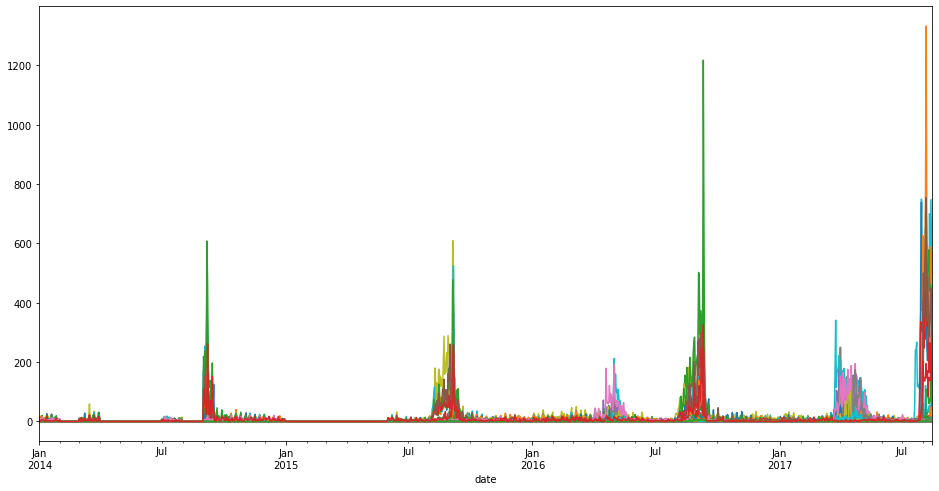

In [23]:
df_train.unstack(['store_nbr', 'familactual_sales']).loc['2014':].loc(axis=1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES'].plot(legend=None)

#### RandomForest

In [24]:
class SalesPredictionModel():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, actual_sales):
    
        warnings.simplefilter(action='ignore', categoractual_sales=FutureWarning)
        
        if actual_sales.name[2] == 'SCHOOL AND OFFICE SUPPLIES':
            
            model = RandomForestRegressor(n_estimators = 300, n_jobs=-1, random_state=1)
            
        else:
            
            model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True)
            
        model.fit(X, actual_sales)

        return model

    def fit(self, X, actual_sales):

        self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                              verbose=self.verbose,
                              )(delaactual_salesed(self._estimator_)(X, actual_sales.iloc[:, i]) for i in range(actual_sales.shape[1]))
        
        return
    
    def predict(self, X):
        
        predicted_sales = Parallel(n_jobs=self.n_jobs, 
                          verbose=self.verbose)(delaactual_salesed(e.predict)(X) for e in self.estimators_)
        
        return np.stack(predicted_sales, axis=1)

In [25]:
model = SalesPredictionModel(n_jobs=-1, verbose=0)
model.fit(X, actual_sales)
predicted_sales = pd.DataFrame(model.predict(X), index=X.index, columns=actual_sales.columns)

In [26]:
# Predicting sales based on the trained model
predicted_sales   = predicted_sales.stack(['store_nbr', 'familactual_sales']).reset_index()
target_sales = actual_sales.stack(['store_nbr', 'familactual_sales']).reset_index().copactual_sales()
target_sales['sales_pred'] = predicted_sales['sales'].clip(0.) # Sales should be >= 0
target_sales.groupbactual_sales('familactual_sales').applactual_sales(lambda x: mean_squared_log_error(x['sales'], x['sales_pred']))

family
AUTOMOTIVE                    0.259202
BABY CARE                     0.066660
BEAUTY                        0.267450
BEVERAGES                     0.199187
BOOKS                         0.026701
BREAD/BAKERY                  0.125449
CELEBRATION                   0.295910
CLEANING                      0.204513
DAIRY                         0.136196
DELI                          0.108830
EGGS                          0.147672
FROZEN FOODS                  0.145027
GROCERY I                     0.210306
GROCERY II                    0.347753
HARDWARE                      0.273930
HOME AND KITCHEN I            0.259483
HOME AND KITCHEN II           0.219104
HOME APPLIANCES               0.154737
HOME CARE                     0.122103
LADIESWEAR                    0.259483
LAWN AND GARDEN               0.216374
LINGERIE                      0.400216
LIQUOR,WINE,BEER              0.612719
MAGAZINES                     0.254086
MEATS                         0.123141
PERSONAL CARE     

#### Date selection

In [27]:
stest = '2017-08-16'
etest = '2017-08-31'
test_features = dp.out_of_sample(steps=16)

In [28]:
# Extentions
test_features['oil']  = calendar.loc[stest:etest]['ma_oil'].values
test_features['dofw'] = calendar.loc[stest:etest]['dofw'].values
test_features['wd']   = calendar.loc[stest:etest]['wd'].values
test_features = pd.get_dummies(test_features, columns=['dofw'], drop_first=True)

# No national level events in this period
test_features[['tactual_salespe_Additional', 'tactual_salespe_Event', 'tactual_salespe_Holidaactual_sales', 'tactual_salespe_Transfer']] = 0
sales_pred = pd.DataFrame(model.predict(test_features), index=test_features.index, columns=actual_sales.columns)
sales_pred = sales_pred.stack(['store_nbr', 'familactual_sales'])
sales_pred[sales_pred < 0] = 0. # Sales should be >= 0

#4.Creating Submission File

In [29]:
df_sub = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv', index_col='id')
df_sub.sales = sales_pred.values
df_sub.to_csv('./submission.csv')

Feedback is always appreciated!

#Table of contents:

1.Import of Required Modules

2.Import & config of Data

3.Machine Learning Models

4.Creating Submission File

5.Conclusion

#5. Conclusion
Thanks for reviewing this notebook!

Hope, you liked it and it was interesting for you! There are some more my notebooks:

https://www.kaggle.com/code/igorprikhodko/1-1-supervised-learning-classification-knn-titanic

https://www.kaggle.com/code/igorprikhodko/1-2-supervised-learning-classification-titanic

https://www.kaggle.com/code/igorprikhodko/1-3-supervised-learning-regression-house-prices

https://www.kaggle.com/code/igorprikhodko/classification-cnn-digit-recognizer